# INFOMATION

### python info
 - Version : 3.6.10
 - Anaconda ver 4.8.2
 
### package info
 - tensorflow ver 2.1.0
 - numpy ver 1.19.1
 - pandas ver 1.1.1

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler as scaler
from sklearn.metrics import mean_squared_error
from varname import nameof
import qgrid

- matplotlib 오류 방지

In [2]:
if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
%matplotlib inline

# SETTING
 ### function

In [3]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        x = time_series[i:i + seq_length,:]
        y = time_series[i + seq_length, [-1]]  # Next close price

        dataX.append(x)
        dataY.append(y)
        if i <=10:
            print('{}번째'.format(i))
            print(x, "->", y)
            print('='*10)
            
    return np.array(dataX), np.array(dataY)

### parameter

In [4]:
# train Parameters
seq_length = 5
data_dim = 4
output_dim = 1
learning_rate = 0.001
iterations = 50

### Data
 - load data

In [5]:
xy = pd.read_csv('test_kk.csv')
qgrid.show_grid(xy,show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

- 시계열 컬럼 삭제 및 부동소수점으로 변환

In [6]:
del xy['date']
xy = xy.values[1:].astype(np.float)
# xy = xy[::-1]  # reverse order (chronically ordered) <- already reverse

- 데이터 시각화

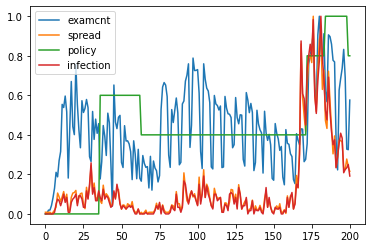

In [7]:
scal = scaler()
scal_tf = scal.fit_transform(xy)

plt.plot(scal_tf[:,[0]],label = 'examcnt')
plt.plot(scal_tf[:,[1]],label = 'spread')
plt.plot(scal_tf[:,[2]],label = 'policy')
plt.plot(scal_tf[:,[3]],label = 'infection')
plt.legend()
plt.show()

- 학습용 / 테스트용 분리

In [8]:
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

 - 스케일링 (Min-Max Scaling)
     > 1. x, y 스케일러 인스턴스 생성
     > 2. x, y 전체 피팅 생성
     > 3. 학습용 / 테스트용 스케일링 변환
     > * 나누는 목적
     >> 나중에 inverse 할때 예상값과 같은 배열 크기여야 가능하다.

In [9]:
min_max_x = scaler()
min_max_y = scaler()

min_max_x_fit = min_max_x.fit(xy[:,:-1])
min_max_y_fit = min_max_y.fit(xy[:,[-1]])

train_set_sc_x = min_max_x.transform(train_set[:, :-1])
train_set_sc_y = min_max_y.transform(train_set[:, [-1]])
test_set_sc_x = min_max_x.transform(test_set[:, :-1])
test_set_sc_y = min_max_y.transform(test_set[:, [-1]])

print(train_set_sc_x[:10])
print('-'*10)
print(train_set[:10,:-1].astype(np.int))
print('-'*10)
print(min_max_x.inverse_transform(train_set_sc_x).astype(np.int)[:10])

[[0.         0.00833591 0.        ]
 [0.00214648 0.00833591 0.        ]
 [0.01901777 0.00833591 0.        ]
 [0.01961879 0.00833591 0.        ]
 [0.04284365 0.         0.        ]
 [0.08246759 0.00833591 0.        ]
 [0.1306345  0.01914171 0.        ]
 [0.21044046 0.03488731 0.        ]
 [0.18755903 0.10558814 0.        ]
 [0.27006955 0.08644643 0.        ]]
----------
[[  55    0    0]
 [ 105    0    0]
 [ 498    0    0]
 [ 512    0    0]
 [1053    0    0]
 [1976    0    0]
 [3098    0    0]
 [4957    0    0]
 [4424    0    0]
 [6346    0    0]]
----------
[[  55    0    0]
 [ 105    0    0]
 [ 498    0    0]
 [ 512    0    0]
 [1053    0    0]
 [1976    0    0]
 [3098    0    0]
 [4957    0    0]
 [4424    0    0]
 [6346    0    0]]


 - 원상복귀 시켜준다.

In [10]:
train_set = np.concatenate((train_set_sc_x,train_set_sc_y), axis=1)
test_set = np.concatenate((test_set_sc_x,test_set_sc_y), axis=1)
print(train_set[:3])
print('-'*10)
print(test_set[:3])

[[0.         0.00833591 0.         0.        ]
 [0.00214648 0.00833591 0.         0.        ]
 [0.01901777 0.00833591 0.         0.        ]]
----------
[[0.55889929 0.02994751 0.4        0.01666667]
 [0.51347987 0.06977462 0.4        0.06666667]
 [0.21911222 0.00833591 0.4        0.        ]]


 - 학습 / 테스트 데이터 구분

In [11]:
print('Data Name is {}'.format(nameof(train_set)))
trainX, trainY = build_dataset(train_set, seq_length)

print('\n\n')

print('Data Name is {}'.format(nameof(test_set)))
testX, testY = build_dataset(test_set, seq_length)

Data Name is train_set
0번째
[[0.         0.00833591 0.         0.        ]
 [0.00214648 0.00833591 0.         0.        ]
 [0.01901777 0.00833591 0.         0.        ]
 [0.01961879 0.00833591 0.         0.        ]
 [0.04284365 0.         0.         0.        ]] -> [0.]
1번째
[[0.00214648 0.00833591 0.         0.        ]
 [0.01901777 0.00833591 0.         0.        ]
 [0.01961879 0.00833591 0.         0.        ]
 [0.04284365 0.         0.         0.        ]
 [0.08246759 0.00833591 0.         0.        ]] -> [0.00833333]
2번째
[[0.01901777 0.00833591 0.         0.        ]
 [0.01961879 0.00833591 0.         0.        ]
 [0.04284365 0.         0.         0.        ]
 [0.08246759 0.00833591 0.         0.        ]
 [0.1306345  0.01914171 0.         0.00833333]] -> [0.05]
3번째
[[0.01961879 0.00833591 0.         0.        ]
 [0.04284365 0.         0.         0.        ]
 [0.08246759 0.00833591 0.         0.        ]
 [0.1306345  0.01914171 0.         0.00833333]
 [0.21044046 0.03488731 0.     

 ### LSTM Modeling
  - 셀 지정

In [12]:
# tf.random.set_seed(777)
tf.model = tf.keras.Sequential()
tf.model.add(tf.keras.layers.LSTM(units=30,input_shape=(seq_length, data_dim), return_sequences=True))
tf.model.add(tf.keras.layers.LSTM(units=30, return_sequences=False))
tf.model.add(tf.keras.layers.Dense(units=output_dim, activation='linear'))
tf.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 30)             4200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 11,551
Trainable params: 11,551
Non-trainable params: 0
_________________________________________________________________


 - Compile 지정

In [13]:
tf.model.compile(loss='mse',
                 # optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                 optimizer='adam',
                 metrics=['accuracy'])

h = tf.model.fit(trainX, trainY, epochs=iterations, batch_size=1, validation_data=[testX,testY])

Train on 135 samples, validate on 61 samples
Epoch 1/50
135/135 [==============================] - 4s 27ms/sample - loss: 0.0023 - accuracy: 0.1333 - val_loss: 0.1116 - val_accuracy: 0.0656
Epoch 2/50
135/135 [==============================] - 0s 3ms/sample - loss: 0.0019 - accuracy: 0.1333 - val_loss: 0.0871 - val_accuracy: 0.0656
Epoch 3/50
135/135 [==============================] - 1s 4ms/sample - loss: 0.0019 - accuracy: 0.1333 - val_loss: 0.1008 - val_accuracy: 0.0656
Epoch 4/50
135/135 [==============================] - 1s 4ms/sample - loss: 0.0019 - accuracy: 0.1333 - val_loss: 0.1003 - val_accuracy: 0.0656
Epoch 5/50
135/135 [==============================] - 0s 4ms/sample - loss: 0.0018 - accuracy: 0.1333 - val_loss: 0.0884 - val_accuracy: 0.0656
Epoch 6/50
135/135 [==============================] - 0s 3ms/sample - loss: 0.0018 - accuracy: 0.1333 - val_loss: 0.0822 - val_accuracy: 0.0656
Epoch 7/50
135/135 [==============================] - 0s 4ms/sample - loss: 0.0019 - accur

 -  Modeling 예측

In [33]:
test_predict = tf.model.predict(testX)

MSE = mean_squared_error(testY,test_predict)
RMSE = np.sqrt(MSE)

pred_score = 100 * ( 1 - (((test_predict - testY)**2).sum())/((testY**2).sum()))

print('MSE : {} , RMSE : {} , score : {}'.format(MSE,RMSE,pred_score))
np.array(min_max_y.inverse_transform(test_predict), dtype=np.int)[:10]

MSE : 0.0976848472569748 , RMSE : 0.3125457522619285 , score : 48.968824627240394


array([[ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 3],
       [ 6],
       [10],
       [ 6],
       [ 8],
       [ 7]])

 - 에러율 검출 시각화 

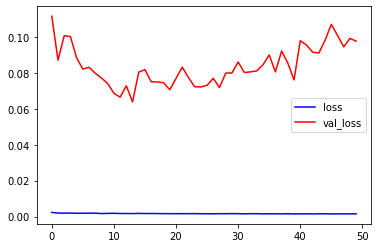

In [15]:
plt.plot(h.history['loss'], label = 'loss', color = 'b')
plt.plot(h.history['val_loss'], label = 'val_loss', color = 'r')
plt.legend()
plt.show()

 - 실제값 vs 예측값 시각화

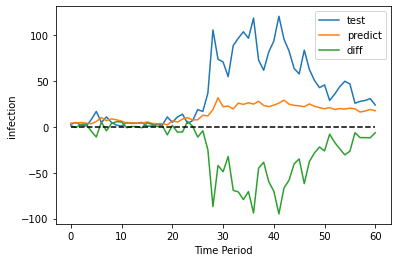

In [30]:
Ty = min_max_y.inverse_transform(testY)
Tp = min_max_y.inverse_transform(test_predict)
Td = Tp - Ty

plt.plot(Ty,label = 'test')
plt.plot(Tp,label = 'predict')
plt.plot(Td,label = 'diff')
plt.plot(np.zeros(len(Td)),'--', color = 'black')
plt.xlabel("Time Period")
plt.ylabel("infection")
plt.legend()
plt.show()

 - 학습 구간 - 예측구간 전체 시각화 도출

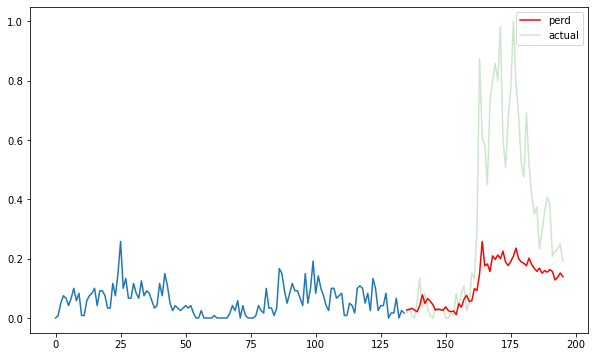

In [20]:
a_axis = np.arange(0,len(trainY))
b_axis = np.arange(len(trainY),len(trainY)+len(test_predict))

plt.figure(figsize=(10,6))
plt.plot(a_axis, trainY.reshape(len(trainY),))
plt.plot(b_axis,test_predict, color='r', label='perd')
plt.plot(b_axis,testY, color='green', alpha=0.2, label='actual')
plt.legend()
plt.show()